## disclaimer
This has been copied, pretty much entirely from: [Accessing Sentinel-1 Level-1 GRD data with the Planetary Computer STAC API](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd#Example-Notebook)

thank you to Microsoft Planetary Computer. The below contains modified Copernicus Sentinel Data (2023)

In [1]:
import pystac_client ### b4c09a5a31134fd1816a5186990e9cab
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

aoi = shape({"coordinates": [
          [[37.19413067439723,-2.9575557865166218],
           [37.19413067439723,-3.181602418203937],
           [37.44806733121189,-3.181602418203937],
           [37.44806733121189,-2.9575557865166218],
           [37.19413067439723,-2.9575557865166218]]
          ],"type": "Polygon"})

time_of_interest = "2021-01-01/2021-06-30"

search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=aoi.bounds,
    datetime=time_of_interest,
)

items = search.item_collection()
print(f"Returned {len(items)} Items")
item = items[3]
date = pd.to_datetime(item.properties['datetime'])
print(date)
# set([item.properties['proj:epsg'] for item in items])

Returned 43 Items
2021-06-18 03:12:16.833982+00:00


In [3]:
vv = (rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
      .astype(float)
      .squeeze())
vh = (rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
      .astype(float)
      .squeeze())

r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)

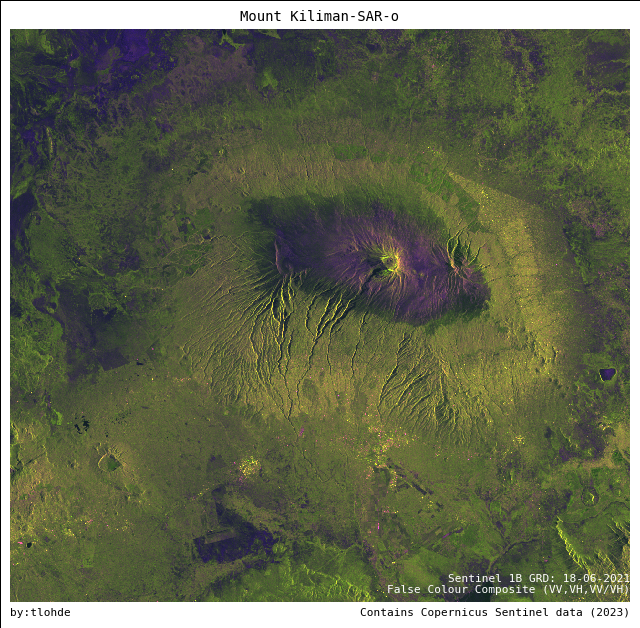

In [5]:
fig, ax = plt.subplots(figsize=[8,8], edgecolor='k', linewidth=0.5)
if item.properties["sat:orbit_state"]=='descending':
    img = np.flip(data, axis=(1, 2)).clip(0, 1).plot.imshow(ax=ax)
else:
    ax.plot.imshow(rgb="band", ax=ax)

ax.set_title(f'Mount Kiliman-SAR-o', fontdict={'font':'DejaVu Sans Mono'})

ax.set_xlim(1200,2500)
ax.set_ylim(400,1600)
ax.set_aspect('equal')
ax.set_axis_off()

ax.annotate(text=f'Sentinel 1B GRD: {date.day}-{"{:02d}".format(date.month)}-{date.year}\nFalse Colour Composite (VV,VH,VV/VH)',
            xy=(1,0.03), xycoords='axes fraction', ha='right', va='center', fontsize=8, font='DejaVu Sans Mono', color='w')

ax.annotate(text='Contains Copernicus Sentinel data (2023)',
            xy=(1,-0.02), xycoords='axes fraction', ha='right', va='center', fontsize=8, font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0,-0.02), xycoords='axes fraction', fontsize=8, va='center', ha='left', font='DejaVu Sans Mono')

fig.savefig('day8.png', bbox_inches='tight', dpi=300)